# 五章　誤差逆伝播法

四章で実装した勾配降下法を用いたニューラルネットワークの学習は、**数値微分**を利用したことで計算に多くの時間がかかりました。そこで今回は**誤差逆伝播法**を用いて高速かつ効率的に勾配を求めてみましょう。

## 計算グラフ

![計算グラフ](https://cdn-ak.f.st-hatena.com/images/fotolife/l/losiz17/20180312/20180312192958.png)

**計算グラフ**とは、計算の過程を上記の図のように表したものです。演算の内容が書かれている円を**ノード**、ノード間を結ぶ直線を**エッジ**と呼びます。基本的に左から右へ計算は進められ、そのことを**順伝播**といいます。一方でその逆は**逆伝播**といいます。これが今章で大事になってきます。

逆伝播は上の図で書かれた右から左のエッジです。一つ一つのエッジは微分の式($ \frac{\partial y}{\partial x} $)で表され、逆伝播はこの微分の式をかけることで行われます。この性質を**連鎖律の原理**と呼び、**合成関数**の考え方が使われています。

## 逆伝播

ここから先は様々な演算の逆伝播を見ていきます。最初は四則演算からです。

加算ノードの逆伝播は非常にシンプルです。例として、上記にもある$ t=x+y $の数式を偏微分してみると、

$$
    \frac{\partial t}{\partial x}=1 \\
    \frac{\partial t}{\partial y}=1
$$

となります。これは加算の逆伝播は値がそのまま伝わることが分かります。

続いて乗算ノードの逆伝播です。ここでは$ z=xy $という式を例にとって考えてみましょう。

$$
    \frac{\partial z}{\partial x}=y \\
    \frac{\partial z}{\partial y}=x
$$

この式からは、乗算ノードの逆伝播が順伝播の時の入力信号を逆に掛けて伝わることになると分かります。

一度これまで習った計算グラフの考え方を具体例を使って表してみます。

![計算グラフ 具体例](https://qiita-image-store.s3.ap-northeast-1.amazonaws.com/0/470838/a5e0cc17-3e26-3e22-140c-627cb7a149ae.png)

この時出てくる逆伝播の値(微分)は「出力データに与える影響度の高さ」と考えるとわかりやすいと思います。

## 実装(序)

先ほど示した計算グラフの例を実装してみましょう。

In [3]:
# 乗算、加算レイヤの定義(レイヤとはニューラルネットワークの機能を一つにまとめたもの)

class MulLayer: #乗算レイヤ
    def __init__(self): #順伝播の入力信号の保持
        self.x = None
        self.y = None

    def forward(self, x, y): #順伝播の計算
        self.x = x
        self.y = y                
        out = x * y

        return out

    def backward(self, dout): #逆伝播の計算
        dx = dout * self.y #dout=微分の値
        dy = dout * self.x

        return dx, dy


class AddLayer: #加算レイヤ
    def __init__(self):
        pass #順伝播の入力信号は関係ない

    def forward(self, x, y):
        out = x + y

        return out

    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1

        return dx, dy

In [4]:
pencil=100 #鉛筆一本の値段
pencil_num=2 #買った鉛筆の本数
eraser=30 #消しゴム一個の値段
eraser_num=3 #買った消しゴムの個数
tax=1.1 #消費税

mul_pencil_layer=MulLayer()
mul_eraser_layer=MulLayer()
add_pencil_eraser_layer=AddLayer()
mul_tax_layer=MulLayer()

pencil_price=mul_pencil_layer.forward(pencil,pencil_num) #鉛筆の値段の合計(税抜)
eraser_price=mul_eraser_layer.forward(eraser,eraser_num) #消しゴムの値段の合計(税抜)
all_price=add_pencil_eraser_layer.forward(pencil_price,eraser_price) #税抜価格
price=mul_tax_layer.forward(all_price,tax) #税込価格

dprice=1 #逆伝播
dall_price,dtax=mul_tax_layer.backward(dprice)
dpencil_price,deraser_price=add_pencil_eraser_layer.backward(dall_price)
deraser,deraser_num=mul_eraser_layer.backward(deraser_price)
dpencil,dpencil_num=mul_pencil_layer.backward(dpencil_price)

print(price)
print(dpencil_num,dpencil,deraser,deraser_num,dtax)

319.0
110.00000000000001 2.2 3.3000000000000003 33.0 290


## 実装(破)

ここからは今までの実装で用いてきたような実際のニューラルネットワークの学習で使う関数をレイヤとして定義します。

### ReLUレイヤ

In [5]:
import numpy as np
from common.functions import *
from common.util import im2col, col2im


class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

In [7]:
# mask変数の機能

x=np.array([[1.0,-0.5],[-2.0,3.0]])
print(x)
mask=(x<=0)
print(mask)

[[ 1.  -0.5]
 [-2.   3. ]]
[[False  True]
 [ True False]]


### Sigmoidレイヤ

In [8]:
class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx

### Affineレイヤ

ニュートラルネットワークの順伝播は行列の積です。そこでその計算(今まではnp.dot(X,W)といった風に計算していた)の順伝播、逆伝播を**Affineレイヤ**として実装します。

In [9]:
class Affine:
    def __init__(self, W, b):
        self.W =W
        self.b = b
        
        self.x = None
        # 重み・バイアスパラメータの微分
        self.dW = None
        self.db = None

    def forward(self, x):
        self.x = x
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        return dx

### Softmax-with-Lossレイヤ

最後に出力層にあたるソフトマックス関数と損失関数である交差エントロピー誤差をまとめて**Softmax-with-Lossレイヤ**として実装します。

In [10]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 損失
        self.y = None # softmaxの出力
        self.t = None # 教師データ (one-hot vector)

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        
        return dx

## 実装(急)

それでは誤差逆伝播法を導入していきましょう。まずは前回も行った二層ニューラルネットワークの実装からです。

In [11]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    # x:入力データ, t:教師データ
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x:入力データ, t:教師データ
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

ここで前回行った数値微分と今回の誤差逆伝播法に本当に差はないのか検証します。

In [12]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

for key in grad_numerical.keys():
    diff = np.average( np.abs(grad_backprop[key] - grad_numerical[key]) )
    print(key + ":" + str(diff))

W1:1.9147008829315543e-10
b1:9.878135252632502e-10
W2:6.984310773060221e-08
b2:1.4036424991342723e-07


値の小ささから勾配の差はかなり小さいとわかりました。とうとう実装です！

0.10255 0.1009
0.7679333333333334 0.776
0.87845 0.8815
0.8992666666666667 0.9017
0.90685 0.909
0.9132 0.9166
0.91845 0.9205
0.9231833333333334 0.9253
0.9254 0.9286
0.92935 0.9317
0.9324666666666667 0.9324
0.9348 0.9352
0.9363666666666667 0.9376
0.939 0.9391
0.9413166666666667 0.9403
0.9431666666666667 0.9411
0.94515 0.9432


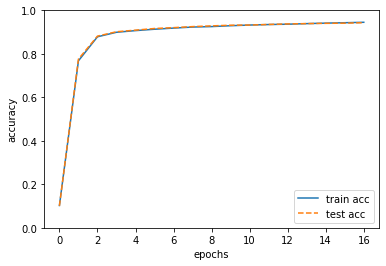

In [13]:
import sys, os
sys.path.append(os.pardir)

import numpy as np
from dataset.mnist import load_mnist
from two_layer_net import TwoLayerNet
import matplotlib.pyplot as plt

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # 更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)

markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

前回とは比べ物にならない速さで実装することができました！これで今章を終わりたいと思います。